In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
import glob
from tqdm import tqdm

DATAROOT = "../dataset"  
TEST_IMG_DIR = os.path.join(DATAROOT, "test/img")
TEST_TXT_DIR = os.path.join(DATAROOT, "test/txt")

MODEL_PATH = "best_model.pth"
IMG_SIZE = 336
BATCH_SIZE = 32

THRESHOLDS = [0.50, 0.40, 0.35, 0.45] 
CLASSES = ["No Defect", "Chipped", "Scratch", "Stain"]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class GlassDataset(Dataset):
    def __init__(self, img_dir, txt_dir, transform=None):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        self.transform = transform
        self.img_files = sorted(glob.glob(os.path.join(img_dir, "*.png")))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        file_name = os.path.basename(img_path)
        txt_name = file_name.replace(".png", ".txt")
        txt_path = os.path.join(self.txt_dir, txt_name)

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (IMG_SIZE, IMG_SIZE))

        if self.transform:
            image = self.transform(image)

        label = torch.zeros(4, dtype=torch.float32)
        if not os.path.exists(txt_path):
            label[0] = 1.0
        else:
            with open(txt_path, "r") as f:
                lines = f.readlines()
            if len(lines) == 0:
                label[0] = 1.0
            else:
                has_defect = False
                for line in lines:
                    try:
                        cid = int(line.strip().split()[0])
                        if 0 <= cid <= 2:
                            label[cid + 1] = 1.0
                            has_defect = True
                    except: continue
                if not has_defect: label[0] = 1.0
        return image, label

def load_model():
    print("Loading model...")
    try:
        model = models.efficientnet_b3(weights=None)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 4)
    except:
        print("Warning: Falling back to ResNet50 (Ensure this matches your training!)")
        model = models.resnet50(pretrained=False)
        model.fc = nn.Linear(model.fc.in_features, 4)
        
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

In [ ]:
def plot_multilabel_confusion_matrix(y_true, y_pred, threshold_list):

    y_pred_binary = np.zeros_like(y_pred)
    for i in range(4):
        y_pred_binary[:, i] = (y_pred[:, i] > threshold_list[i]).astype(float)
        

    mcm = multilabel_confusion_matrix(y_true, y_pred_binary)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('Per-Class Confusion Matrices (Multi-label)', fontsize=16)
    
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):

        tn, fp, fn, tp = mcm[i].ravel()

        sns.heatmap(mcm[i], annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Predicted Neg', 'Predicted Pos'],
                    yticklabels=['Actual Neg', 'Actual Pos'],
                    annot_kws={"size": 14})
        
        ax.set_title(f'Class: {CLASSES[i]}\n(Threshold: {threshold_list[i]})', fontsize=14)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        ax.set_xlabel(f'Precision: {precision:.2f} | Recall: {recall:.2f} | F1: {f1:.2f}', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('confusion_matrix_multilabel.png')
    print("Saved: confusion_matrix_multilabel.png")
    plt.show()

def plot_overall_confusion_matrix(y_true, y_pred):

    y_true_idx = np.argmax(y_true, axis=1)
    y_pred_idx = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true_idx, y_pred_idx)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix (Argmax / Dominant Class)', fontsize=16)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_overall.png')
    print("Saved: confusion_matrix_overall.png")
    plt.show()


In [ ]:
def main():

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = GlassDataset(TEST_IMG_DIR, TEST_TXT_DIR, transform=val_transform)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    

    model = load_model()
    all_preds = []
    all_labels = []
    
    print("Running inference...")
    with torch.no_grad():
        for images, labels in tqdm(loader):
            images = images.to(DEVICE)

            p1 = torch.sigmoid(model(images))
            p2 = torch.sigmoid(model(torch.flip(images, [3]))) 
            p3 = torch.sigmoid(model(torch.flip(images, [2]))) 
            avg_probs = (p1 + p2 + p3) / 3.0
            
            all_preds.append(avg_probs.cpu().numpy())
            all_labels.append(labels.numpy())
            
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    plot_multilabel_confusion_matrix(all_labels, all_preds, THRESHOLDS)

    plot_overall_confusion_matrix(all_labels, all_preds)


Loading model...
Running inference...


100%|██████████| 328/328 [00:33<00:00,  9.93it/s]


Saved: confusion_matrix_multilabel.png


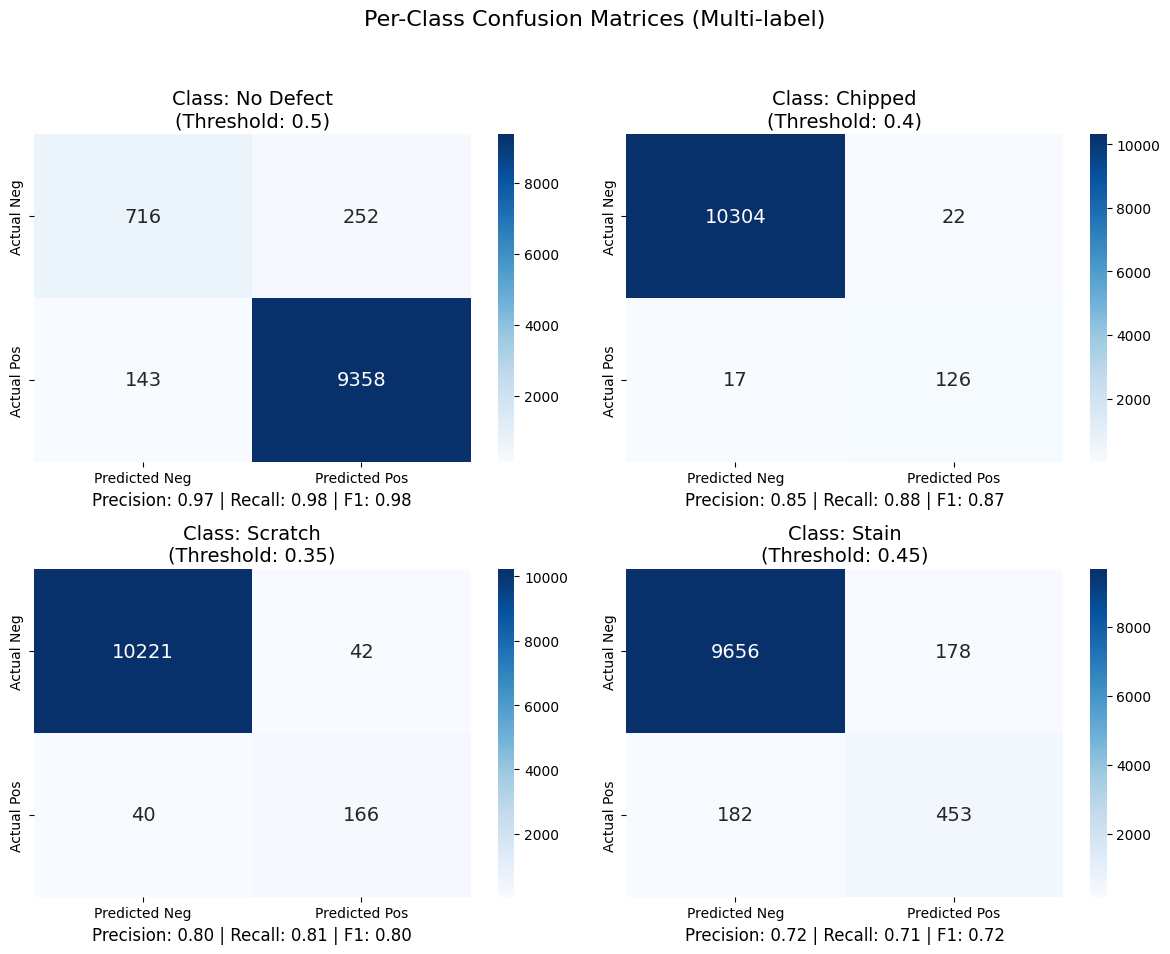

Saved: confusion_matrix_overall.png


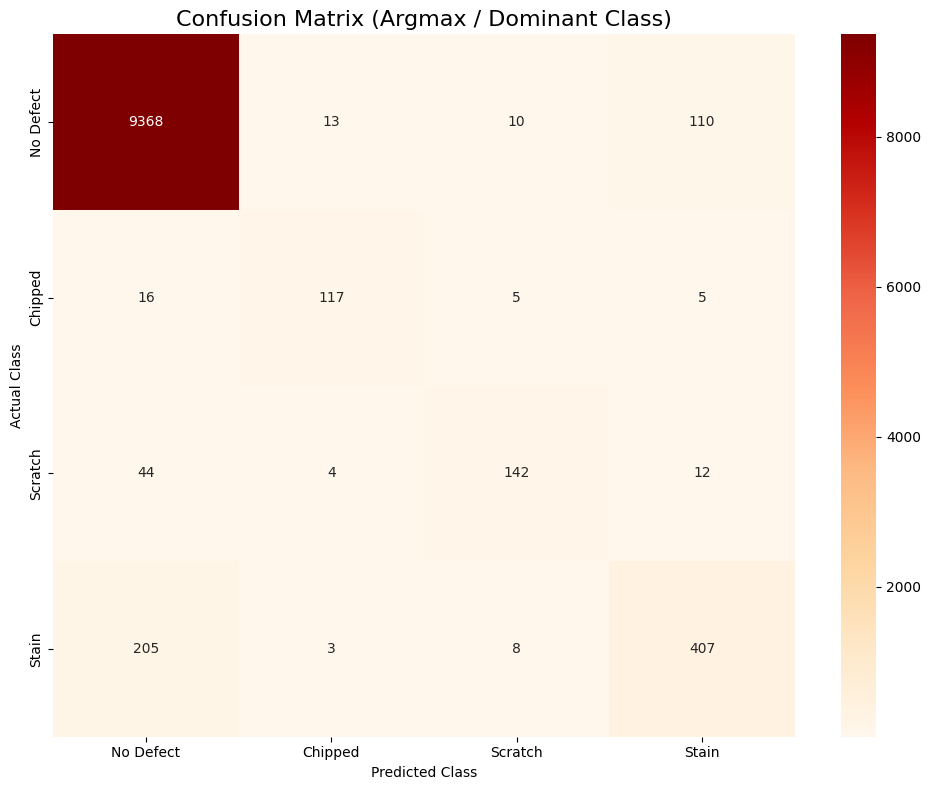

In [11]:
if __name__ == "__main__":
    main()